## PS
* run anything above work space  
* then modify L and K 

In [2]:
import networkx as nx
from numpy.linalg import matrix_power
import numpy as np
import matplotlib.pyplot as plt
import copy as cp

In [69]:
plt.rcParams["figure.figsize"] = (18, 13)

In [55]:
def isklburnable(g, k, l):
    '''
    input:
    g: graph with networkx form
    k: number of sources
    l: number of rounds
    '''
    ############################################ Step0: get information
    N = nx.number_of_nodes(g)
    g_copy = cp.deepcopy(g)
    ''''''
    ########################################### Step1: get L
    L_list, tellburnfromL = getL(g, N, l, k)
    print(tellburnfromL)
    if tellburnfromL == True:
        return np.array(L_list[0]), [x for x in g.nodes()], True
    
    ########################################### Step2: initial
    source = -1*np.ones(k) #burnding sequence
    bestsequence = [[], []] #1st entry: burning sequence; 2nd: number of burned nodes by this bs
    
    R_dynamic = [cp.copy(L_list[0])]
    burned = []
    level_burned = [[]] 
    burned, source, level_burned, R_dynamic = updateR(k, L_list, g, 0, burned, source, level_burned, R_dynamic)
    
    #New check
    if len(burned) == N:
        return source, burned, True 

    ########################################### Step3: loop   
    while len(R_dynamic) != 0:
        while len(R_dynamic[k - 1]) != 0:
            '''1. check: finish burn k rounds'''
            # 1.1 pick source at end of round
            source[k - 1] = R_dynamic[k - 1][0] # pick 1st 
            R_dynamic[k-1].remove(R_dynamic[k - 1][0]) #remove 1st
            burned.append(source[k-1]) 
            burned = list(set(burned))
            
            if len(burned) == N:
                return source, burned, True
           
            '''2. burned B for rest rounds'''
            B = cp.copy(burned)# assign for iteration
            for rest_rounds in range(l - k): #l-k
                B = findB(B, g)
                B = list(set(burned))# remove replication
                if len(B) == N:
                    return source, B, True
                
            '''3. fail to burn '''
            burned.remove(source[k-1])
            if len(bestsequence[1]) < len(B):
                print('Best sequence', bestsequence[0], bestsequence[1])
                bestsequence[0] = cp.copy(source)
                bestsequence[1] = cp.copy(B)    
        
        
        #update variables to return 
        source[k-1] = -1
        del R_dynamic[-1]  
        level_burned[k - 2].remove(source[k - 2])
        del level_burned[k-1]
        upburned = []
        for i in level_burned:
            upburned = upburned + i
        
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, k-2, upburned, source, level_burned, R_dynamic) #go back to upper level 0, 1, ..., k-2, k-1 
        
        if len(burned) == N:
            return source, burned, True  
    
    return bestsequence[0], bestsequence[1], False

def getL(g, N, l, k):
    L_list = [[x for x in g.nodes()]]
    tellburnedfromL = False
    num_remove = 0
    
    gl = cp.deepcopy(g) #used for l
    initial = range(N) 
    for i in range(l - 1):
        leaves = updateL(initial, gl)
        initial = cp.deepcopy(leaves)
        L_list.append(initial)
    L_list.reverse()
    
    while(len(L_list[0]) == 0):
      del L_list[0]
      tellburnedfromL = True
      num_remove = num_remove + 1
    if len(L_list[0]) == 1:
      tellburnedfromL = True
    '''
    print("1得到L")
    print(L_list)
    print("\n")
    '''
    return L_list, tellburnedfromL

def updateL(input, g):#S1 get all leaves
    temp = [x for x in g.nodes() if g.degree(x)<=1] 
  #S2.1 remove leaves from graph
    for i in range(len(temp)): 
      g.remove_node(temp[i])
  #S2.2 return all non-leaves 
    return [x for x in input if x not in temp]

def findB(burned, gg):
    '''
        input: 
        a) burned: list of burned nodes
        b) gg: total graph
        output:
        nodes_burned_till_this_round
    '''
    nodes_burned_till_this_round = cp.copy(burned)
    # find all bunred vertice's neignbors
    for this_node in burned:
        nb_of_source = nx.all_neighbors(gg, this_node)
            
        for x in nb_of_source:
            if x not in nodes_burned_till_this_round: # keep unique
                nodes_burned_till_this_round.append(x)
    
    return nodes_burned_till_this_round #返回B set

def updateR(k, L_list, g, num, burned, source, level_burned, R_dynamic):
    # 0 judge and recursion
    '''0 precheck: walk upwards if the R set this level is empty'''
    if len(R_dynamic[num]) == 0: #this row does not exist
        if num == 0:
            del R_dynamic[-1]
            return burned, source, level_burned, R_dynamic
            
        del R_dynamic[num]
        del level_burned[num]
        level_burned[num - 1].remove(source[num - 1])
        
        #upburned will replace burned
        upburned = []
        for i in level_burned:
            upburned = upburned + i
        
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, num - 1, upburned, source, level_burned, R_dynamic)
        return burned, source, level_burned, R_dynamic


    '''1 normal process'''    
    # 1.the process of pick new source after burning
    
    max_degree = -1
    for i in R_dynamic[num]:
        if g.degree[i] > max_degree:
            source[num] = i
            max_degree = g.degree[i]
            
    R_dynamic[num].remove(source[num])
    burned.append(source[num])
    burned = list(set(burned)) # remove
    old_burned = cp.copy(burned)
    level_burned[num].append(source[num])

    # 2. update R
    # 2.1 get all burned nodes(B) in this round
    B = findB(burned, g)#TODO: copy? # PS: 也可以让findB只返回新burn的vertices
    # 2.2 update level_burn
    level_burned.append([node for node in B if node not in old_burned])#all burned this round - all burned last round
    burned = cp.copy(B) #update burn
    # 2.3 get L/B and update to the total R
    R_next_level = [node for node in L_list[num + 1] if node not in burned] #update R next level
    # deal with empty R
    if len(R_next_level) == 0:
        # case1: no lower options
        if num + 2 == len(L_list): 
            return burned, source, level_burned, R_dynamic
        
        # case2: walk down
        for inner_num in range(num + 2, len(L_list)): #choose [num + 2, ..., l - 1]
            R_next_level = [node for node in L_list[inner_num] if node not in burned]
            # A. get new set, end find
            if len(R_next_level) != 0:
                break
            # B. reach end and all empty
            if inner_num == len(L_list) - 1:
                R_dynamic.append(R_next_level)#put empty ?
                return burned, source, level_burned, R_dynamic
          
    R_dynamic.append(R_next_level)
    # 3. Walk down: if have not reach the k-1 level， to next level(0, 1, ..., k-2, k-1)
    if num < k - 2: #TODO: deal with new change of L_list (and num < len(L_list) - 2)
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, num + 1, burned, source, level_burned, R_dynamic)   
    return burned, source, level_burned, R_dynamic
  

In [33]:
def show(G, sources, burnt):
    labels = {}
    valid_source = len(sources)
    for i in range(len(sources)):
        if sources[i] != -1:
            labels[sources[i]] = i + 1
        if sources[i] == -1:
            valid_source = i
            break
            
    print(labels, len(labels))
    
    pos=nx.spring_layout(G)
    ''' '''
    pos_copy = cp.copy(pos)
    nx.draw_networkx(G, pos=pos_copy,arrows=None, with_labels=True)
    plt.show()
    
    nx.draw_networkx(G, pos=pos,arrows=None, with_labels=False)    # plot original graph
    nx.draw_networkx(G, pos=pos,nodelist = burnt,arrows=None, node_color="tab:green",with_labels=False) # represent burnt nd
    
    if (len(labels) != 0) :
        nx.draw_networkx(G, pos=pos,nodelist = sources[:valid_source],arrows=None, node_color="tab:red",with_labels=False) # represnet sources
        description = nx.draw_networkx_labels(G,pos=pos,labels=labels)    # plot sources' 

def drawgraph(g_target, k, l):
    gs, gb, gt = isklburnable(g_target, k, l)
    print("can burned", gt)
    print("burning sequence is", gs)
    show(g_target, gs, gb)   


# Work space

In [78]:
N = 22
k = 22
test_graph = nx.path_graph(36)


False
can burned True
burning sequence is [342. 282. 467.  33.  45. 256. 480.  56.  77.  72. 457. 157. 242. 290.
  90.  47. 262.  79.  76. 127.  -1.  -1.]
{342.0: 1, 282.0: 2, 467.0: 3, 33.0: 4, 45.0: 5, 256.0: 6, 480.0: 7, 56.0: 8, 77.0: 9, 72.0: 10, 457.0: 11, 157.0: 12, 242.0: 13, 290.0: 14, 90.0: 15, 47.0: 16, 262.0: 17, 79.0: 18, 76.0: 19, 127.0: 20} 20


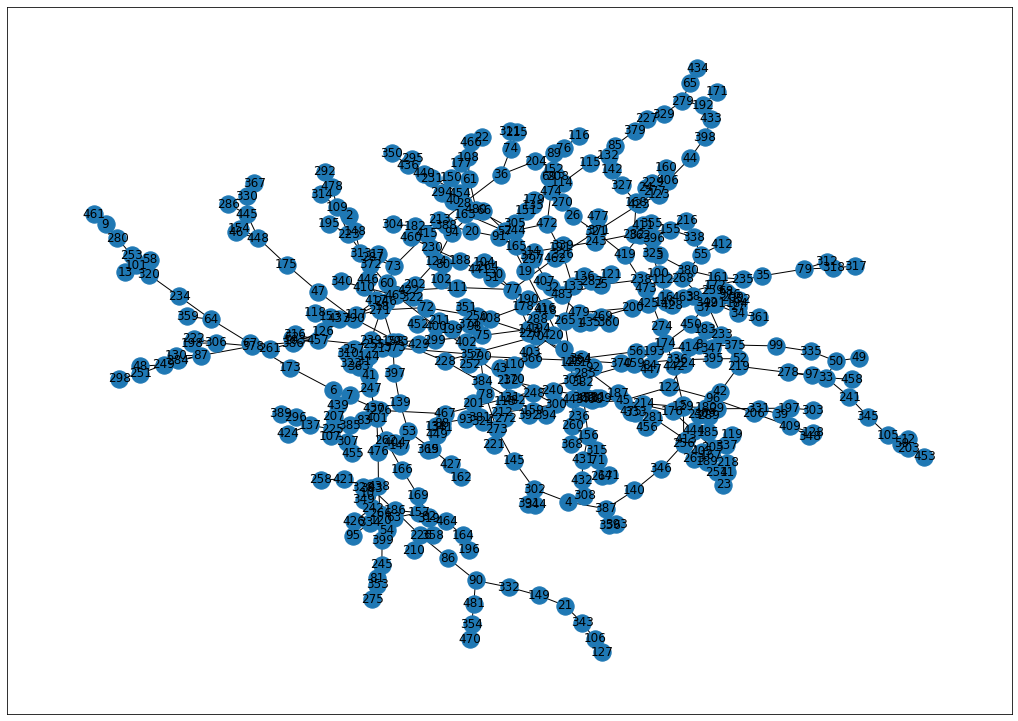

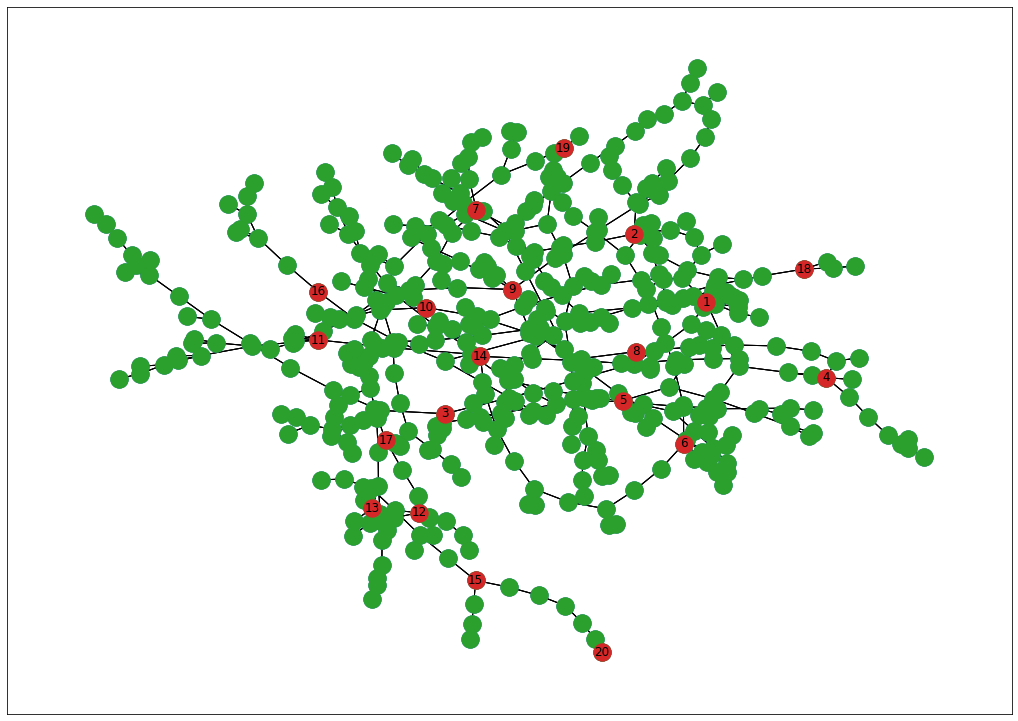

In [79]:
test_graph2 = nx.random_tree(N*k)
drawgraph(test_graph2, k, N)